In [1]:
%%capture
!pip install numpy pandas typing statsmodels networkx plotly seaborn

In [2]:
# Data
import numpy as np
import pandas as pd
from typing import Set
# Statistical models
import statsmodels.api as sm
# Plots
import networkx as nx
import plotly.graph_objs as go
import seaborn as sns

# Potential Outcomes

By Alessio Zanga, Niccolò Rocchi and Fabio Stella

## Abstract

This notebook illustrates a step-by-step example on estimating the average causal effect (ACE) of sodium on blood pressure following [Luque-Fernandez et al. (2018)](https://academic.oup.com/ije/article/48/2/640/5248195). The main focus of this work is to highlight the differences between a naive estimate and the adjusted estimate.

## Introduction

Exceeding the recommendations for 24-h dietary **sodium** (SOD) intake is associated with increased levels of **systolic blood pressure** (SBP). Furthermore, with advancing **age**, the adaptive mechanism responsible for maintaining the composition and volume of the extracellular fluid is compromised. Age is a common cause of both high systolic blood pressure and impaired sodium homeostasis, acting as a confounder. However, high levels of 24-h excretion of **urinary protein** (PRO) are caused by sustained high SBP and increased dietary SOD, acting as a collider.

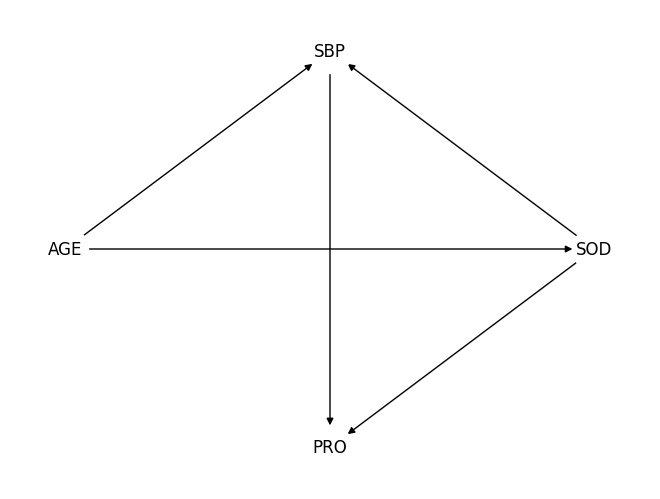

In [3]:
G = nx.DiGraph()
G.add_edges_from([("SOD", "SBP"), ("AGE", "SOD"), ("AGE", "SBP"), ("SOD", "PRO"), ("SBP", "PRO")])
nx.draw_circular(G, node_size=1000, node_color="white", with_labels=True)

Assuming **linear relationships** between the variables and **gaussian noise**, a data generation process that is consistent with the represented causal graph follows directly.

In [4]:
def sample_data(size: int = int(1e6), seed: int = 31):
    # Set random generator seed for results reproducibility
    np.random.seed(seed)
    # Sample age with mean 65 and std 5
    age = np.random.normal(65, 5, size)
    # Sample sodium with additive noise
    sod = 0.056 * age + np.random.normal(0, 1, size)
    # Binarize sodium following cutoff
    sod = (sod > 3.5).astype(int)
    # Sample systolic blood pressure
    sbp = 1.05 * sod + 2 * age + np.random.normal(0, 1, size)
    # Sample urinary protein
    pro = 0.4 * sod + 0.3 * sbp + np.random.normal(0, 1, size)
    # Create a dataframe from sampled variables
    return pd.DataFrame({"AGE": age, "SOD": sod, "SBP": sbp, "PRO": pro})

Here, the true ACE is given by the coefficient 1.05 that assign SBP a value given SOD.

In [5]:
data = sample_data()
data.describe()

,AGE,SOD,SBP,PRO
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,65.001134,0.552995,130.583161,39.396720
std,4.993518,0.497184,10.161539,3.263477
min,40.964418,0.000000,82.816817,24.421988
25%,61.627703,0.000000,123.720103,37.190745
50%,65.009236,1.000000,130.597297,39.402344
75%,68.372794,1.000000,137.445514,41.602773
max,87.717317,1.000000,176.708462,54.573313


## Methods

The average causal effect (ACE), also called average treatment effect (ATE), from $X$ to $Y$ is defined as:

$$ \tau = \mathbb{E}[Y(1) - Y(0)]$$

Assuming SUTVA, positivity and unconfoundedness, the ACE can be identified by the use of the **adjustment formula** and a valid adjustment set $\mathbf{Z}$:

$$ \tau = \mathbb{E}[Y(1) - Y(0)] = \mathbb{E}_\textbf{Z}[\mathbb{E}[Y(1) - Y(0)|\textbf{Z}]] = \mathbb{E}_\textbf{Z}[\mathbb{E}[Y|X=1,\textbf{Z}] - \mathbb{E}[Y|X=0,\textbf{Z}]] $$

Remember how the expected value of a discrete random variable $Z$ is defined:

$$ \mathbb{E}[Z] = \sum_{\text{Dom}(Z)} z P(z) $$

Now, let's indicate $n$ the size of the data set and $n_z$ the raw frequency of a level $z \in \text{Dom}(Z)$ into the data. We can then estimate $\mathbb{E}[Z]$ from data by simply use these frequencies:

$$ \mathbb{E}[Z] = \sum_{\text{Dom}(Z)} z P(z) \approx \sum_{\text{Dom}(Z)} z \frac{n_z}{n} = \frac{1}{n}\sum_{\text{Dom}(Z)}z n_z = \frac{1}{n} \sum_{i=1}^n z_i $$

We are finally able to give $\tau$ an estimation through our data, that is replacing $\mathbb{E}_{\mathbf{Z}}[\cdots]$ with the empirical mean:

$$ \hat{\tau} = \frac{1}{n} \sum_{i=1}^{n} [\mathbb{E}[Y|X=1,\textbf{Z}=\mathbf{z_{i}}] - \mathbb{E}[Y|X=0,\textbf{Z}=\mathbf{z_{i}}]] $$

However, instead of computing $\mathbb{E}[Y|X, \mathbf{Z}]$ as averages from data, it is possible to choose any machine learning model for $\mathbb{E}[Y|X,\textbf{Z}]$, such as a linear regression model. Such model works out nicely since blood pressure is generated as a linear combination of other variables.

In [ ]:
def ACE(data: pd.DataFrame, X: str, Y: str, Z: Set[str]):
    # Define the regresion model formula
    formula = f"{Y} ~ {X}"
    if len(Z) != 0: formula += "+" + "+".join(Z)
    # Fit Ordinary Least Square regression model
    estimator = sm.OLS.from_formula(formula, data).fit()
    # Compute potential outcomes by fixing X
    Y1 = estimator.predict(data.assign(**{X: 1}))
    Y0 = estimator.predict(data.assign(**{X: 0}))
    # Compute average causal effect
    return np.mean(Y1 - Y0)

## Results

The true ACE is:

In [ ]:
ace = 1.05

The naive estimated ACE without adjustment is:

In [ ]:
t = ACE(data, X = "SOD", Y = "SBP", Z = [])
f"Estimated ACE: {t:.3}, Relative Error: {(np.abs((t-ace)/ace*100)):.4}%"

'Estimated ACE: 5.37, Relative Error: 411.5%'

The estimated ACE adjusting for AGE and PRO is:

In [ ]:
t = ACE(data, X = "SOD", Y = "SBP", Z = ["AGE", "PRO"])
f"Estimated ACE: {t:.3}, Relative Error: {(np.abs((t-ace)/ace*100)):.4}%"

'Estimated ACE: 0.856, Relative Error: 18.46%'

The estimated ACE adjusting for AGE is:

In [ ]:
t = ACE(data, X = "SOD", Y = "SBP", Z = ["AGE"])
f"Estimated ACE: {t:.3}, Relative Error: {(np.abs((t-ace)/ace*100)):.4}%"

'Estimated ACE: 1.05, Relative Error: 0.2269%'

So {AGE} is a valid adjustment set. Note that the relative error is not 0 even in this case, because of the noise into the system.

## Adjustment in graphical terms

The naive estimated ACE represents the correlation between SOD and SBP, that is the increase in SBP due to SOD, in average.

In [ ]:
# Generate data
data = sample_data(size = 1000)
# Create base trace
trace = go.Scatter(
    x=data['SOD'],
    y=data['SBP'],
    mode='markers',
    marker=dict(
        size=5,
        color=data['SBP'],
        colorscale='Viridis',
        opacity=0.8
    ),
    showlegend = False
)
# Create regression line
estimator = sm.OLS.from_formula("SBP ~ SOD", data).fit()
X = np.linspace(data['SOD'].min(), data['SOD'].max(), 2)
Y = np.zeros(2)
for i in range(2):
  Y[i] = estimator.predict({"SOD": X[i]})
line = go.Scatter(
    x=X,
    y=Y,
    opacity=0.5,
    line = {"width" : 3, "color" : "blue"},
    showlegend = False
)
# Create figure
fig = go.Figure(data=[trace, line])
fig.update_layout(
    xaxis_title="SOD",
    yaxis_title="SBP",
    width = 6e2
)
# Show plot
fig.show()

If we add AGE into the regression formula, the correlation coefficient for SOD is different. This coefficient represents the increase in SBP due to SOD **for each strata of AGE**, in average.

In [ ]:
# Generate data
data = sample_data(size = 1000)
# Create base trace
trace = go.Scatter3d(
    x=data['AGE'],
    y=data['SOD'],
    z=data['SBP'],
    mode='markers',
    marker=dict(
        size=1.8,
        color=data['SBP'],
        colorscale='Viridis',
        opacity=0.8
    )
)
# Create regression plane
estimator = sm.OLS.from_formula("SBP ~ AGE + SOD", data).fit()
x = np.linspace(data['AGE'].min(), data['AGE'].max(), 5)
y = np.linspace(data['SOD'].min(), data['SOD'].max(), 2)
X, Y = np.meshgrid(x, y)
Z = np.zeros((2, 5))
for i in range(2):
    for j in range(5):
        Z[i][j] = estimator.predict({"AGE": x[j], "SOD": y[i]})
plane = go.Surface(
    x=X,
    y=Y,
    z=Z,
    opacity=0.5,
    colorscale='Viridis',
    showscale=False
)
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='AGE'),
        yaxis=dict(title='SOD'),
        zaxis=dict(title='SBP')
    )
)
# Create figure
fig = go.Figure(data=[trace, plane], layout = layout)
fig.update_layout(
    width = 7e2
)
# Show plot
fig.show()

## Conclusions

Applying a naive regression model without adjustment leads to an estimated ACE which is four times off. A regression model with a valid adjustment set reduce the relative error to only 0.22%.

But how to identify such valid set? *Stay tuned!*